# Проект для "Викишоп" с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.sample(5)

,Unnamed: 0,text,toxic
25976,26010,""" November 2014 (UTC)\n\nI have read the IHE a...",0
42216,42266,Well no crap we're the same person because thi...,0
42030,42080,Your edits to 1970-71 NHL Season,0
18414,18433,What do reliable sources have to say regarding...,0
639,639,"""\nSee Internet_Explorer#Market share history ...",0


In [5]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
data.duplicated().sum()

0

Данные содержат 159292 наблюдения. Пропусков и дубликатов в данных нет.

Удалим столбец `Unnamed: 0`

In [7]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на распределение классов в данных

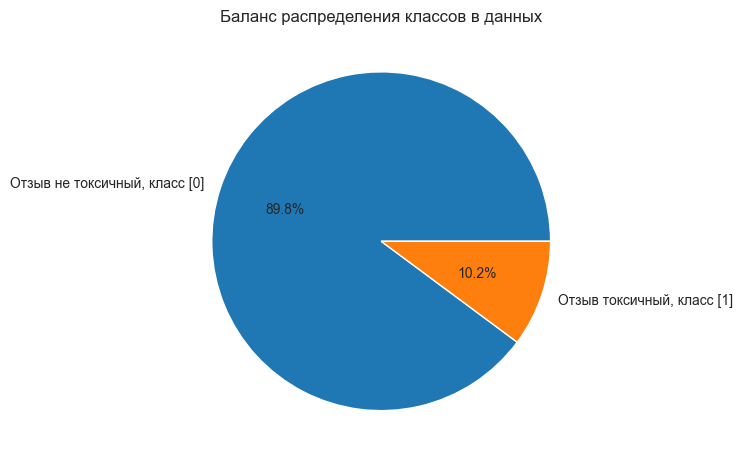

In [9]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(
    kind='pie', 
    figsize=[5.5, 5.5], 
    legend=False, 
    autopct='%1.1f%%',
    labels=['Отзыв не токсичный, класс [0]', 'Отзыв токсичный, класс [1]']
)
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

Видно, что тут явный дисбаланс, будем учитывать это при обучении.

Токенизация и создание эмбеддингов с помощью `bert-base-uncased`

In [11]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')


tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = transformers.BertModel.from_pretrained('unitary/toxic-bert').to(device)

batch_size = 100
embeddings = []

padded = torch.tensor(padded, dtype=torch.long, device=device)
attention_mask = torch.tensor(attention_mask, dtype=torch.long, device=device)

for i in tqdm(range((padded.shape[0] + batch_size - 1) // batch_size)):
    batch = padded[batch_size * i:batch_size * (i + 1)]
    attention_mask_batch = attention_mask[batch_size * i:batch_size * (i + 1)]
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

features = np.concatenate(embeddings)

100%|██████████| 1593/1593 [08:35<00:00,  3.09it/s]


Разделим наш датасет на обучающуюся и тестовую выборку

In [14]:
RS = 2033

In [15]:
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(features, y,
                                                    random_state=RS,
                                                    test_size=0.1,
                                                    stratify=y
)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(143362, 768)
(15930, 768)
(143362,)
(15930,)


### LogisticRegression

In [ ]:
param_grid = {
    
    }

model_LR = LogisticRegression(random_state=RS)

grid_search = GridSearchCV(estimator=model_LR, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best F1 Score:", grid_search.best_score_)
best_score_LR = grid_search.best_score_

Best F1 Score: 0.9464156524783591


### CatBoostClassifier

In [ ]:

param_grid = {
    'iterations': [10, 100],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [1, 3]
}

model_cb = CatBoostClassifier(verbose=0, random_state=RS, task_type='GPU')

grid_search = GridSearchCV(estimator=model_cb, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

print("Best F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)
best_score_cb = grid_search.best_score_
best_params_cb = grid_search.best_params_

Best F1 Score: 0.9475049052557531
Best Parameters: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


### LGBMClassifier

In [ ]:
param_grid = {
    'n_estimators': [10, 100],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 20],
}

model_lgbm = LGBMClassifier(class_weight='balanced', random_state=RS, device='gpu')

grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)
best_score_lgbm = grid_search.best_score_

[LightGBM] [Info] Number of positive: 14567, number of negative: 128795
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 143362, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (105.00 MB) transferred to GPU in 0.026466 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best F1 Score: 0.9320472463143658
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 20}


In [19]:
result = {'model': ['LogisticRegression', 'CatBoostClassifier', 'LGBMClassifier'],
'f1': [best_score_LR, best_score_cb, best_score_lgbm]}

results = pd.DataFrame(result)
results

,model,f1
0,LogisticRegression,0.946416
1,CatBoostClassifier,0.947505
2,LGBMClassifier,0.932047


Лучше все себя показала модель CatBoostClassifier. Проверим ее на тестовых данных

In [21]:
model = CatBoostClassifier(verbose=0, random_state=RS, task_type='GPU', **best_params_cb)
model.fit(X_train, y_train)

predict = model.predict(X_test)
f1 = f1_score(y_test, predict)
print("F1:", f1)

F1: 0.9412126808248692


Визуализация матрицы ошибок в виде тепловой карты

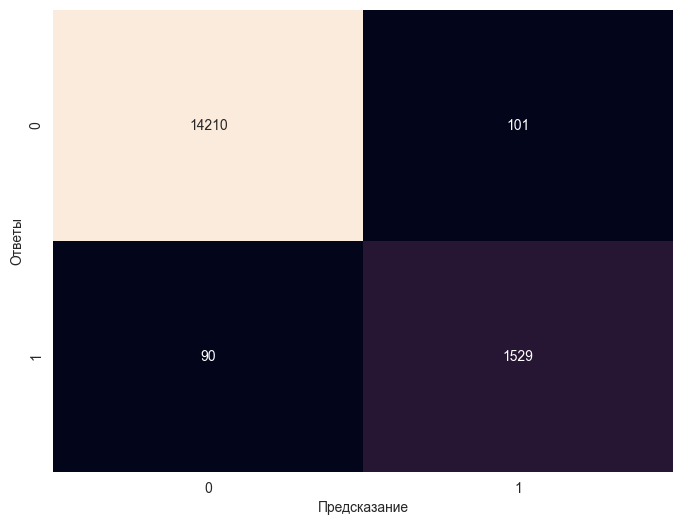

In [22]:
cm = confusion_matrix(y_test, predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Предсказание')
plt.ylabel('Ответы')
plt.show()

Модель отлично предсказывает как негативные, так и положительные отзывы.

## Вывод

Были проделаны следующие шаги:
- Загружены данные.
- С помощью модели BERT были обработанны и закодированны текстовые признаки.
- Были обучены три модели машинного обучения - LogisticRegression, CatBoostClassifier, и LGBMClassifier.
- Выбрана наилучшая модель CatBoostClassifier, итоговый показатель качества которой, по метрике F1 на тестовой выборке, составил 0.94.